Read in the data using your specific path

In [1]:
import numpy as np
import matplotlib as mpl
import csv
import matplotlib.pyplot as plt
import pandas as pd
from pre_and_post_valuations_data import transaction_data_file, block_data_file, pre_geth_file, \
    geth_reccomendation_file, suite_spot_txn, suite_spot_blx



#Read in the data, use your own machines specific path as you see fit
transaction_data=pd.read_csv(transaction_data_file)
block_data=pd.read_csv(block_data_file)
pre_geth=pd.read_csv(pre_geth_file)
geth_r=pd.read_csv(geth_reccomendation_file)
suite_txn=pd.read_csv(suite_spot_txn)
suite_blx=pd.read_csv(suite_spot_blx)

Use previously written code to clean and combine datasets

In [2]:

#######################################################################################################################
## ADDING THE GAS LIMITS AND BASE FEE INTO THE DATAFRAME
#######################################################################################################################
## first we put the gas limits as well as the base fee into the  transaction dataframe
#######################################################################################################################


#######################################################################################################################
## ADDING THE GAS LIMITS AND BASE FEE INTO THE DATAFRAME
#######################################################################################################################
## first we put the gas limits as well as the base fee into the  transaction dataframe
#######################################################################################################################





#Get the block number and gas limits and base fee from the dataset
my_block_number=list(block_data.block_number)
my_gas_limit=list(block_data.gas_limit)
my_base_fee=list(block_data.base_fee_per_gas)
#initialize a dictionary to assign gas limits and base fee to the transaction data
gas_limit_tracker={}
base_fee_tracker={}


#makes a dicionary with the key being the block number and the 
#value being the gas limits and base fee, because this will allow us to 
#easily assign a gas limit and base fee to the transaction going forward
for i in range(len(my_block_number)):
    gas_limit_tracker[my_block_number[i]]=my_gas_limit[i]
    base_fee_tracker[my_block_number[i]]=my_base_fee[i]
    
    
##get the block numbers from the transaction data
transaction_block_numbers=list(transaction_data.block_number)


#initialize a list for the purpose of saving the gas limits that will 
#be assigned to the transaction data and assign the correct information
gas_limits_for_transaction_data=[gas_limit_tracker[x] for x in transaction_block_numbers]
base_fee_for_transaction_data=[base_fee_tracker[x] for x in transaction_block_numbers]

    
#add the column into the dataframe
#transaction_data['gas_limit']=gas_limits_for_transaction_data
transaction_data['base_fee']=base_fee_for_transaction_data


# The final step is to remove the NA's from then dataframe, from testing of the 
# dataset, i have found that the max priority fee per gas and the max fee per gas
# have the the same number of NA's -this can be oberved with the line 
# np.sum(transaction_data.isna())- that we can remove the NA's with the line...
transaction_data=transaction_data[pd.notnull(transaction_data.max_fee_per_gas)]


#######################################################################################################################
## RESCALING THE GAS PRICES
#######################################################################################################################
## now we need to add another column to revert the gas price into a metric that we 
## can compare to the pre EIP 1559 data. to do this, we will need to work under the
## assumption that gas limits represent the same metric that they do in the pre EIP 
## 1559 network (which is an assumption that the previous paper made that we will 
## continue in this proposal). then, we see that the user bid has a specific value 
## in the post EIP 1559 section which is min(base fee + tip , max tip), while in the pre EIP section the userbid is equal 
## to gas price * gas limit. Therefore, if we set these metrics to be equal, we can 
## solve for the equivilent of the gas prices in the post EIP section by taking the 
## min(base fee + tip , max tip) and dividing it by the gas limit
#######################################################################################################################


#get all the values...
b_fee=list(transaction_data.base_fee)
g_limit=list(transaction_data.gas)
m_fee=list(transaction_data.max_fee_per_gas)
tip=list(transaction_data.max_priority_fee_per_gas)


#Get the user bid for the specified transaction
user_bid=[min(b_fee[x]+tip[x],m_fee[x]) for \
                    x in range(len(b_fee))]


#Evaluate and store the rescaled gas prices
rescaled_gas_prices=[min(b_fee[x]+tip[x],m_fee[x])/g_limit[x] for \
                    x in range(len(b_fee))]


#add the gas prices and user bid back into the dataframe
transaction_data['rescaled_gas_prices']=rescaled_gas_prices
transaction_data['user_bid']=user_bid


*Generate the post EIP valuations and reccomendations*

In [3]:
#grab the block numbers from the dataset
my_blocks=list(set(list(transaction_data.block_number)))


#grab the usable block numbers, as we cant derive reccomendations from the 
#first 100 blocks because the reccomendation is based on the previous 100 
#blocks
usable_blocks=my_blocks[101:]
#get the first block
usable_blocks[0]




#initialize a list to contain the minimum
min_list=[]

#this loop goes through each of the 
#usable blocks, finds the lowest rescaled gas price, 
#then gets the bid associated with that
#gas price, and then adds it to the min_list
for i in my_blocks:        
    current_itteration=transaction_data[transaction_data.block_number == i]
    bid_values=list(current_itteration.user_bid)
    min_value=np.min(current_itteration.rescaled_gas_prices)
    my_index=list(current_itteration.rescaled_gas_prices).index(min_value)
    min_list.append(bid_values[my_index])
    
        
        
        
#initialize a list to contain the geth reccomendations
geth_reccomendation=[]


for i in range(len(usable_blocks)):
    geth_reccomendation.append(np.percentile(min_list[i:i+100],60))

    
#use only the usable blocks for our final dataframe  
final_dataframe=transaction_data[transaction_data.block_number >= usable_blocks[0]]


#initialize a dictionary to contain the geth reccomendations
geth_r_tracker={}

#assign the values based on the block number
for i in range(len(usable_blocks)):
    geth_r_tracker[usable_blocks[i]]=geth_reccomendation[i]
    
    
#get the blocks from the dataframe
my_final_blocks=list(final_dataframe.block_number)

#initialize a list that will contain the geth reccomendation
geth_r_for_dataframe=[]

#assign the ressomendation
for i in my_final_blocks:
    geth_r_for_dataframe.append(geth_r_tracker[i])
    
#put the reccomendation back into the dataframe
final_dataframe['geth_recommendation']=geth_r_for_dataframe


#calculate the valuations according to the methodology of the 
#last paper
final_dataframe['valuations']=final_dataframe['user_bid'] / final_dataframe['geth_recommendation']


#display the results to the user
display(final_dataframe)

/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_8169/1103052264.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe['geth_recommendation']=geth_r_for_dataframe
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_8169/1103052264.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe['valuations']=final_dataframe['user_bid'] / final_dataframe['geth_recommendation']


,hash,block_number,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,gas_used,base_fee,rescaled_gas_prices,user_bid,geth_recommendation,valuations
516516,0x4ecc6a513ce1c02e1367c7bca169233d7da61a721d54...,12968054,0.000000e+00,120000,40658350000,4.065835e+10,4.065835e+10,2,43713,34209998215,3.388196e+05,4.065835e+10,3.996289e+10,1.017403
516524,0x9128b87ba28e3bdbb40491ea5d3ec4fffd9bdf24638e...,12968054,0.000000e+00,250000,39209998215,7.200000e+10,5.000000e+09,2,57206,34209998215,1.568400e+05,3.921000e+10,3.996289e+10,0.981160
516787,0x49d63c1b486c0f99c05a5ab4970919684fb23b056c12...,12968055,5.000000e+16,211131,40107493816,4.010749e+10,4.010749e+10,2,201299,32526865584,1.899650e+05,4.010749e+10,4.000419e+10,1.002582
516859,0x865c8eedc70ff15750ced3ed0d714bf8eb440ddd9e33...,12968055,7.075910e+15,21000,36526865584,7.800000e+10,4.000000e+09,2,21000,32526865584,1.739375e+06,3.652687e+10,4.000419e+10,0.913076
516903,0x27d26ab8a6a69e82e4b50e899622e7d193bdb097119c...,12968055,0.000000e+00,362127,35050243944,3.505024e+10,3.505024e+10,2,212973,32526865584,9.678992e+04,3.505024e+10,4.000419e+10,0.876164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883769,0xec1a176e7a2cc37389bf2ff27a169a240f1734c33a08...,12969997,2.804744e+16,3000000,29635881520,2.963588e+10,0.000000e+00,2,121233,29635881520,9.878627e+03,2.963588e+10,3.457162e+10,0.857231
883770,0x31eca90accfcb17e2d85dfc6418d420988067bf856e6...,12969997,0.000000e+00,1000000,34505402509,3.450540e+10,3.450540e+10,2,210545,29635881520,3.450540e+04,3.450540e+10,3.457162e+10,0.998085
883837,0xfa623209d41ba4409537b5739d4fa0abbefd687313c2...,12969997,4.109970e+15,42000,31502952651,3.150295e+10,1.867071e+09,2,21000,29635881520,7.500703e+05,3.150295e+10,3.457162e+10,0.911237
883853,0xeb54da76c9059da24af786d1dc97f76da7faebbc9e97...,12969998,0.000000e+00,1000000,165487905007,1.654879e+11,1.654879e+11,2,122846,28080959215,1.654879e+05,1.654879e+11,3.435404e+10,4.817131


*Pre geth valuations*

In [4]:
##get the blocks and predictions
blocks=list(geth_r.block_number)
predictions=list(geth_r.pre_geth_predictions)


#grab the first relevant block
genesis=blocks[0]


#initialize a dictionary to assign block values
block_checker={}


#assigns proper prediction values
for i in range(len(blocks)):
    block_checker[blocks[i]]=predictions[i]
    
    
#limit to appropriate blocks and then 
pre_geth=pre_geth[pre_geth.block_number >= genesis]
pre_block_numbers=list(pre_geth.block_number)


##assigns a list for new reccomendations
new_rec=[]
for i in pre_block_numbers:
    new_rec.append(block_checker[i])


#evaluates the valuations
pre_geth['geth_reccomendations']=new_rec
pre_geth['valuations']=pre_geth['gas_price'] / pre_geth['geth_reccomendations']


#gets valuations
val=list(pre_geth.valuations)


##remove outliers, use 0.4 as a lower because
#observations are in that region that do not represent the 
##data as a whole and will skew our observations
p_up=np.percentile(val,95)
p_lo=0.4
n_val=[x for x in val if (x < p_up) & (x > p_lo)]


##generates random indexes to be used later
def random_index_generator(my_list,num_of_indexes):
    my_max=len(my_list)-1
    result=np.random.uniform(0,my_max,num_of_indexes)
    return [round(x) for x in result]

##gets the indexes, 
my_indexes=random_index_generator(n_val,23278)
##assigns values
random_valuations=[n_val[x] for x in my_indexes]


##display the results to the user
display(pre_geth)

,hash,block_number,block_timestamp,receipt_gas_used,gas_price,geth_reccomendations,valuations
0,0xc9d37faf9270c0aa1a553d4e53777cf1617a606d8a26...,12111333,2021-03-26 00:16:51 UTC,45764,129000000000,1.230000e+11,1.048780
1,0xceeee703a7638bfa1eaa0c3d97f31fe211dfb77915e6...,12111413,2021-03-26 00:33:17 UTC,36601,168000000000,1.368000e+11,1.228070
2,0x87007e41f34e2c1ea51fe9ff5bde4a039c70f2a218fe...,12111458,2021-03-26 00:42:19 UTC,21000,174000000000,1.340000e+11,1.298507
3,0x497a2de3a8a8a2799ead2bb558ba072cbb50c1f2ab8a...,12111280,2021-03-26 00:06:07 UTC,154315,168211840178,1.110000e+11,1.515422
4,0x548aa6b360f2b81f0ed437b35af5405dfce857069e71...,12111328,2021-03-26 00:15:32 UTC,21000,154000000000,1.220000e+11,1.262295
...,...,...,...,...,...,...,...
6264787,0xac03a458748d87b1e03732c7a60f13d3f6278e2dfb84...,12088722,2021-03-22 12:53:38 UTC,21000,165000000000,1.490000e+11,1.107383
6264788,0xa10fa129bc83a7d7b85391b7c85ae579b3ab59ef6fd0...,12088822,2021-03-22 13:15:19 UTC,21000,213000000000,1.640000e+11,1.298780
6264789,0xa43bb8f1b1d77b3f9770311998bc667e4e393e022021...,12085526,2021-03-22 00:58:55 UTC,112866,181000000000,1.490000e+11,1.214765
6264790,0x5a90c80b066cd7577c71ee1e891353535d6e5f16f75c...,12087380,2021-03-22 07:54:46 UTC,21000,6000000000,9.832000e+10,0.061025


*Suite spot valuations*

In [5]:
#Get the block numbers
suite_blocks=list(suite_blx.block_number)


#this loop goes through each of the 
#usable blocks, finds the lowest rescaled gas price, 
#then gets the bid associated with that
#gas price, and then adds it to the min_list
usable_blocks=suite_blocks[101:]
genesis_block=usable_blocks[0]
for i in suite_blocks:        
    current_itteration=suite_txn[suite_txn.block_number == i]
    min_list.append(np.min(current_itteration.gas_price))
    
             
#initialize a list to contain the geth reccomendations
geth_reccomendation=[]


for i in range(len(usable_blocks)):
    geth_reccomendation.append(np.percentile(min_list[i:i+100],60))

    
#use only the usable blocks for our final dataframe  
final_s_dataframe=suite_txn[suite_txn.block_number >= usable_blocks[0]]


#initialize a dictionary to contain the geth reccomendations
geth_s_tracker={}


#assign the values based on the block number
for i in range(len(usable_blocks)):
    geth_s_tracker[usable_blocks[i]]=geth_reccomendation[i]
    
    
#get the blocks from the dataframe
my_final_blocks=list(final_s_dataframe.block_number)


#initialize a list that will contain the geth reccomendation
geth_r_for_dataframe=[]


#assign the ressomendation
for i in my_final_blocks:
    geth_r_for_dataframe.append(geth_s_tracker[i])
    

#put the reccomendation back into the dataframe
final_s_dataframe['geth_recommendation']=geth_r_for_dataframe


#calculate the valuations according to the methodology of the 
#last paper
s_gas_price=list(final_s_dataframe.gas_price)
s_geth_reccomendation=list(final_s_dataframe.geth_recommendation)


s_valuations=[]
for i in range(len(s_gas_price)):
    if s_geth_reccomendation[i] == 0:
        s_valuations.append(np.nan)
    else:
        s_valuations.append(s_gas_price[i] / s_geth_reccomendation[i])


final_s_dataframe['valuations']=s_valuations
display(final_s_dataframe)

/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_8169/1548004421.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_s_dataframe['geth_recommendation']=geth_r_for_dataframe
/var/folders/l8/p0_hwx4d2hvbqs4crpsfjlzc0000gn/T/ipykernel_8169/1548004421.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_s_dataframe['valuations']=s_valuations


,transaction_hash,gas_used,block_number,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,geth_recommendation,valuations
1,0x000015d98e888070d57d3c5a0a13fdc98debc60db20c...,54028,12486126,0,420000,100000000000,NaN,NaN,0,NaN,NaN
2,0x00001702c816339ab5bf4828db878f4a491cb210dbc2...,21000,12491460,46294560000000000,42000,156000000000,NaN,NaN,0,NaN,NaN
3,0x00001a05727a34ff1e266d2aee642bb1224cc5120e0d...,98907,12484237,0,149965,32000000000,NaN,NaN,0,0.000000e+00,NaN
4,0x00001c97d7933221477163a5a455b62782d46ebe0129...,52089,12482717,0,250000,66000000000,NaN,NaN,0,1.000000e+09,66.000000
5,0x00001d572476b1e71902d8e80ac4dd132038ca9cd415...,105448,12483537,0,400000,74800000001,NaN,NaN,0,1.000000e+09,74.800000
...,...,...,...,...,...,...,...,...,...,...,...
3244124,0xffffe2a191b24ef1c45758c00a6829d020ea9a314811...,57206,12478662,0,207128,260000000000,NaN,NaN,0,7.187079e+10,3.617603
3244125,0xffffebc5c0c4fe197d30b718560aea51e5cd90135950...,21000,12477701,99005303008755000,21000,63318904345,NaN,NaN,0,6.902756e+10,0.917299
3244127,0xffffecf72e334919ca841412706841c860197d0f8fa6...,21000,12482744,671605216238268861,21000,56000000000,NaN,NaN,0,NaN,NaN
3244128,0xfffff681bf85b914b03cb20dc2ccc9f9236685b60b76...,171357,12487685,0,215607,36300000000,NaN,NaN,0,NaN,NaN


*Plotting the valuations*


While the vast majority of valuations were between 0 and 1.5, some were as large as 45, rendering the histogram practically meaningless and unable to draw any kind of interpretation. the first thing to do is to remove the outliers. the lowest and highest 5% will be removed for the pre_EIP data, we see that the pre_EIP data has a larger amount of variance than the post_EIP data, specifically, (as last semester noted), there is a noticable number of outliers coming from a extremely small group of miners at around the 0-0.2 mark. Therefore, we will remove this bottom portion of the data to get a more accurate comparison. Furthermore, we will choose a random equal amount of data form each pool to get a more accurate comparison.

*First we will utilize the non ideal data*

After using appropriate methods to remove outliers, the following histograms were obtained. The results indicate that the post oracles are actually opperating more accurately than the pre network, and opperating with less variance. We see that a valuation close to one signifies that the geth prediction is opperating soundly. Therefore, a rudamentary way to test the accuracy iof a given valuation would be to take n observations from each dataset, and for each of the i observations, sum the absolute value of (1-n_i). NOTE: if we assume that the mean of the valuations is one, than this metric can be interpreted as a measure of variance.

 

For pre EIP: 

The valuation accuracy index is: 4131.663617589712

 

For post EIP: 

The valuation accuracy index is: 2241.6250864518997


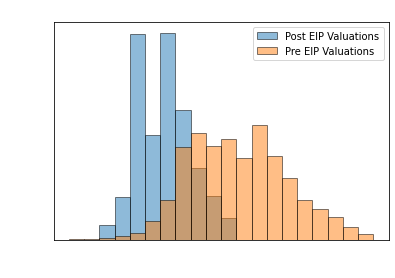

In [6]:
#grab the appropriate valuations
my_valuations=list(final_dataframe.valuations)
#remove the most extreme outliers
p_up=np.percentile(my_valuations,95)
p_lo=np.percentile(my_valuations,5)
my_valuations=[x for x in my_valuations if (x <= p_up) & (x>= p_lo)]


#create the plotting objects
fig = plt.figure()
ax = plt.axes()


#plot the figure
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y',colors='white')
ax.title.set_color('white')
ax.set_ylabel('Frequency')
ax.set_xlabel('Bins (In incriments of 0.05)')
ax.set_title('Pre and Post EIP Valuations')
bins_list_1=list(np.arange(0.6,1.65,0.05))
plt.hist(my_valuations,bins=bins_list_1,ec='black',alpha=0.5,label='Post EIP Valuations')
plt.hist(random_valuations,bins=bins_list_1,ec='black',alpha=0.5,label='Pre EIP Valuations')
ax.legend(loc='upper right')


#Display the results to the user
print('After using appropriate methods to remove outliers, the following histograms were obtained. ' + \
    'The results indicate that the post oracles are actually opperating more accurately than the pre network, ' + \
        'and opperating with less variance. We see that a valuation close to one signifies that the geth prediction ' + \
            'is opperating soundly. Therefore, a rudamentary way to test the accuracy iof a given valuation would be to ' + \
                'take n observations from each dataset, and for each of the i observations, sum the absolute value of ' + \
                    '(1-n_i). NOTE: if we assume that the mean of the valuations is one, than this metric can be interpreted ' + \
                        'as a measure of variance.')
print('\n \n')

def valuation_accuracy_index_getter(my_list):
    string='The valuation accuracy index is: '
    return print(string + str(sum([abs(1-x) for x in my_list])))

print('For pre EIP: \n')
valuation_accuracy_index_getter(random_valuations)
print('\n \n')
print('For post EIP: \n')
valuation_accuracy_index_getter(my_valuations)


##use this line to get a copy of the "complete" transaction dataset
#final_dataframe.to_csv('transaction_df_valuations')
#pre_geth.to_csv('pre_geth_valuations')

*Now we will utalize the ideal data*

Fascinatingly, we see that the valuations for the pre valuations within  the flashbot era are FAR more varied that in the post EIP framework, and appear to have more values skewed towards the right, with the geth price oracles overshooting the mark more often than not
 

For pre EIP: (suite spot) 

The valuation accuracy index is: 233904.95015308206

 

For post EIP: 

The valuation accuracy index is: 2241.6250864518997


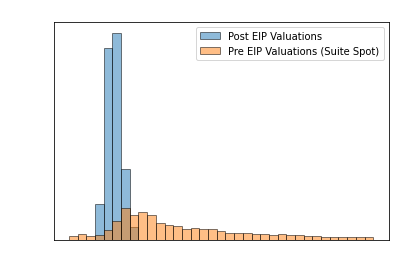

In [7]:
#there are a fair amount of nulls within the dataset, so now we must remove them
#and grab the gas prices
my_suite_valuations=list(final_s_dataframe[pd.notnull(final_s_dataframe.valuations)].valuations)


#a funcrion to generate random indexes
def random_index_generator(my_list,num_of_indexes):   
    my_max=len(my_list)-1
    result=np.random.uniform(0,my_max,num_of_indexes)
    return [round(x) for x in result]


my_indexes=random_index_generator(my_suite_valuations,23278)
s_valuations=[my_suite_valuations[x] for x in my_indexes]
s_hi=np.percentile(my_suite_valuations,95)
s_lo=np.percentile(my_suite_valuations,5)
s_valuations=[x for x in s_valuations if (x <= s_hi) & (x>= s_lo)]


fig2 = plt.figure()
ax2 = plt.axes()


#plot the figure
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y',colors='white')
ax2.title.set_color('white')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Bins (In incriments of 0.05)')
ax2.set_title('Pre and Post EIP Valuations')
bins_list_1=list(np.arange(0.4,4,0.1))
plt.hist(my_valuations,bins=bins_list_1,ec='black',alpha=0.5,label='Post EIP Valuations')
plt.hist(s_valuations,bins=bins_list_1,ec='black',alpha=0.5,label='Pre EIP Valuations ' \
         + '(Suite Spot)')
ax2.legend(loc='upper right');


print('Fascinatingly, we see that the valuations for the pre valuations within ' + \
      ' the flashbot era are FAR more varied that in the post EIP framework, and ' + \
     'appear to have more values skewed towards the right, with the geth price oracles ' + \
     'overshooting the mark more often than not' '\n \n')


print('For pre EIP: (suite spot) \n')
valuation_accuracy_index_getter(s_valuations)
print('\n \n')
print('For post EIP: \n')
valuation_accuracy_index_getter(my_valuations)